In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# 경고 메시지가 뜨지 않게 설정
import warnings 
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 인코딩
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# 검정
from scipy import stats
# 로지스틱 모델 만들기
from statsmodels.formula.api import logit

# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [2]:
df = pd.read_parquet('open/concat/2018_회원정보.parquet')

In [3]:
df

,기준년월,ID,남녀구분코드,연령,Segment,회원여부_이용가능,회원여부_이용가능_CA,회원여부_이용가능_카드론,소지여부_신용,소지카드수_유효_신용,...,할인금액_제휴연회비_B0M,청구금액_기본연회비_B0M,청구금액_제휴연회비_B0M,상품관련면제카드수_B0M,임직원면제카드수_B0M,우수회원면제카드수_B0M,기타면제카드수_B0M,카드신청건수,Life_Stage,최종카드발급경과월
0,201807,TRAIN_000000,2,40대,D,1,1,0,1,1,...,0,0,0,0개,0개,0개,0개,0,자녀성장(2),22
1,201807,TRAIN_000001,1,30대,E,1,1,1,1,1,...,0,0,0,0개,0개,0개,0개,0,자녀성장(1),18
2,201807,TRAIN_000002,1,30대,C,1,1,0,1,1,...,0,0,0,0개,0개,0개,0개,0,자녀출산기,20
3,201807,TRAIN_000003,2,40대,D,1,1,0,1,2,...,0,0,0,0개,0개,0개,0개,1,자녀성장(2),17
4,201807,TRAIN_000004,2,40대,E,1,1,1,1,1,...,0,0,0,0개,0개,0개,0개,1,자녀성장(1),15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,201812,TEST_99995,2,60대,None,0,0,0,0,0,...,0,0,0,0개,0개,0개,0개,0,노년생활,0
2999996,201812,TEST_99996,1,30대,None,1,1,1,1,1,...,0,0,0,0개,0개,0개,0개,0,자녀출산기,12
2999997,201812,TEST_99997,2,30대,None,1,1,1,1,1,...,0,0,0,0개,0개,0개,0개,0,자녀성장(1),11
2999998,201812,TEST_99998,1,30대,None,1,1,1,1,3,...,0,0,0,0개,0개,0개,0개,0,가족구축기,1


### 의미없는 컬럼 제거

In [61]:
import statsmodels
print(statsmodels.__version__)

0.14.4


In [4]:
# 데이터의 도수의 종류가 1개인 데이터를 변수에 담는다.
cols_same_value = df.columns[df.nunique() == 1]

In [5]:
df.drop(list(cols_same_value), axis = 1, inplace = True)

### 결측치를 가진 컬럼 리스트에 담기

In [6]:
na_box = []

for idx, val in df.isna().sum().items() :
    # print(f'{idx}의 결측치 : {val}')
    if val > 0 :
        na_box.append(idx)

In [7]:
na_box

['Segment',
 '가입통신회사코드',
 '직장시도명',
 '_1순위신용체크구분',
 '_2순위신용체크구분',
 '최종유효년월_신용_이용가능',
 '최종유효년월_신용_이용',
 '최종카드발급일자']

- test 데이터의 Segment는 모두 결측치로 되어있다.
- 다른 칼럼의 경우 결측치 비율에 따라 처리한다.

In [8]:
df[na_box].isna().sum() / df.shape[0]

Segment           0.200000
가입통신회사코드          0.161551
직장시도명             0.102401
_1순위신용체크구분        0.011727
_2순위신용체크구분        0.399334
최종유효년월_신용_이용가능    0.087865
최종유효년월_신용_이용      0.223016
최종카드발급일자          0.017606
dtype: float64

### 결측 데이터 처리

1. 가입통신회사코드

In [9]:
df['가입통신회사코드'].value_counts(normalize = True, dropna = False)

가입통신회사코드
S사      0.414263
K사      0.236048
L사      0.188138
None    0.161551
Name: proportion, dtype: float64

In [12]:
# 최빈값 대체
df.fillna({'가입통신회사코드' : df['가입통신회사코드'].mode()[0]}, inplace = True)

In [13]:
df['가입통신회사코드'].isna().sum()

0

2. 직장시도명

In [16]:
df['직장시도명'].value_counts(normalize = True, dropna = False)

직장시도명
경기      0.249122
서울      0.240303
None    0.102401
인천      0.061039
부산      0.054921
대전      0.050299
충북      0.043271
경남      0.039189
경북      0.034727
대구      0.031864
울산      0.027486
전남      0.022010
광주      0.014270
충남      0.011776
전북      0.008534
강원      0.006419
세종      0.001298
제주      0.001072
Name: proportion, dtype: float64

In [33]:
# 직장시도명과 거주시도명을 비교해 본다.
a1 = df.loc[(df['직장시도명'].notna()) & (df['직장시도명'] == df['거주시도명'])].shape[0]
print(round(a1 / sum(df['직장시도명'].notna()), 3))

0.964


- 직장시도명 컬럼이 결측치가 아닌 데이터 중 96.4% 정도가 일치한다.
- 직장시도명 컬럼은 삭제한다.

In [34]:
df.drop('직장시도명', axis = 1, inplace = True)

3. _1순위신용체크구분
- 해당 컬럼의 결측치는 미비한 수준이니 대표값으로 단순대체한다.

In [40]:
df['_1순위신용체크구분'].value_counts()

_1순위신용체크구분
신용    2868437
체크      96382
Name: count, dtype: int64

In [41]:
df.fillna({'_1순위신용체크구분' : df['_1순위신용체크구분'].mode()[0]}, inplace = True)

In [42]:
df['_1순위신용체크구분'].isna().sum()

0

4. _2순위신용체크구분

In [44]:
df['_2순위신용체크구분'].value_counts(normalize = True, dropna = False)

_2순위신용체크구분
None    0.399334
신용      0.363516
체크      0.237150
Name: proportion, dtype: float64

In [48]:
a1 = sum((df['_2순위신용체크구분'].notna()) & (df['_2순위신용체크구분'] == df['_1순위신용체크구분']))
print(a1 / sum(df['_2순위신용체크구분'].notna()))

0.5832162872635193


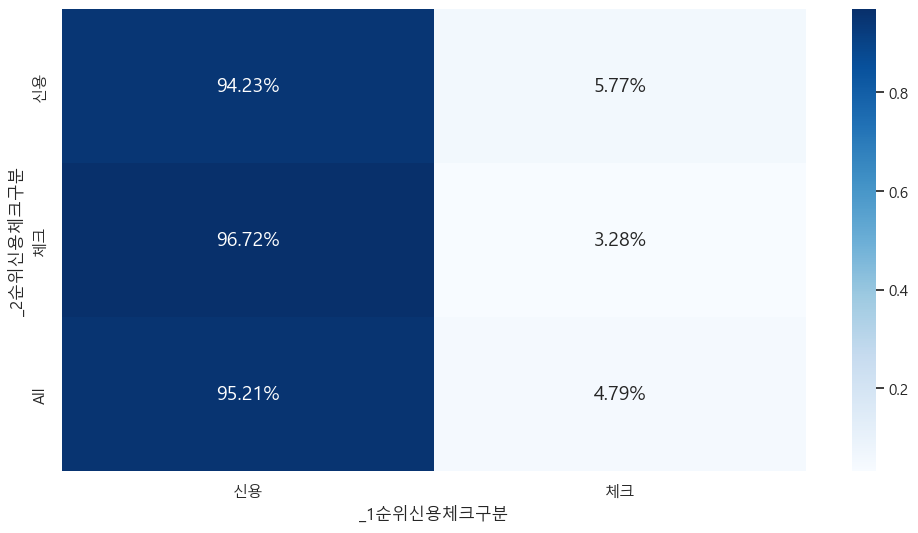

In [58]:
ct1 = pd.crosstab(df.loc[df['_2순위신용체크구분'].notna(), '_2순위신용체크구분'],
                 df.loc[df['_2순위신용체크구분'].notna(), '_1순위신용체크구분'],
                 normalize = 'index',
                 margins = True)

sns.heatmap(ct1, annot = True, fmt = '.2%', cmap = 'Blues')
plt.show()

- 데이터의 분포에서 결측치의 비율이 가장 크다.
- 두 분포의 비율이 비슷하다.
- _2순위신용체크구분은 삭제한다.

In [64]:
df.drop('_2순위신용체크구분', axis = 1, inplace = True)

In [65]:
na_box = []

for idx, val in df.isna().sum().items() :
    # print(f'{idx}의 결측치 : {val}')
    if val > 0 :
        na_box.append(idx)

In [66]:
na_box

['Segment', '최종유효년월_신용_이용가능', '최종유효년월_신용_이용', '최종카드발급일자']

In [67]:
df[na_box]

,Segment,최종유효년월_신용_이용가능,최종유효년월_신용_이용,최종카드발급일자
0,D,202110.0,202112.0,20160912.0
1,E,202112.0,202204.0,20170122.0
2,C,202111.0,202201.0,20161113.0
3,D,202201.0,202111.0,20170205.0
4,E,202201.0,NaN,20170409.0
...,...,...,...,...
2999995,None,NaN,NaN,NaN
2999996,None,202306.0,202304.0,20171203.0
2999997,None,202206.0,NaN,20180125.0
2999998,None,202402.0,202312.0,20181122.0


In [75]:
cat_cols = ['연령', '가입통신회사코드', '거주시도명', '_1순위신용체크구분', '연회비발생카드수_B0M', 'Life_Stage']
for col in cat_cols :
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 67 columns):
 #   Column              Dtype  
---  ------              -----  
 0   기준년월                int64  
 1   ID                  object 
 2   남녀구분코드              int64  
 3   연령                  int32  
 4   Segment             object 
 5   회원여부_이용가능           int64  
 6   회원여부_이용가능_CA        int64  
 7   회원여부_이용가능_카드론       int64  
 8   소지여부_신용             int64  
 9   소지카드수_유효_신용         int64  
 10  소지카드수_이용가능_신용       int64  
 11  입회일자_신용             int64  
 12  입회경과개월수_신용          int64  
 13  회원여부_연체             int64  
 14  이용거절여부_카드론          int64  
 15  동의여부_한도증액안내         int64  
 16  수신거부여부_TM           int64  
 17  수신거부여부_DM           int64  
 18  수신거부여부_메일           int64  
 19  수신거부여부_SMS          int64  
 20  가입통신회사코드            int32  
 21  탈회횟수_누적             int64  
 22  최종탈회후경과월            int64  
 23  탈회횟수_발급6개월이내        int64  
 24  탈회횟수_발급1년이내         int6

In [77]:
df.to_csv('data/회원정보_전처리.csv', index = False)